# Step 1: Initial Image Affine Registration

DK52 has many structure COMs already manually annotatted. The goal in this step is to register DK52 to DK43, so we can later transform DK52's structure COMs to DK43 as a initial guess for further processing.

In [1]:
import json
import time
from pathlib import Path

import SimpleITK as sitk
import airlab as al
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
a = np.array([1, 2])

In [3]:
np.append(a, 1)

array([1, 2, 1])

## Configuration

In [4]:
THIS_DIR = Path().resolve()
DATA_DIR = Path('/net/birdstore/Active_Atlas_Data/data_root/pipeline_data')

In [5]:
mov_img_dir = DATA_DIR / 'DK52/preps/CH1/full_aligned'
mov_img_thumb_dir = DATA_DIR / 'DK52/preps/CH1/thumbnail_aligned'
fix_img_dir = DATA_DIR / 'DK43/preps/CH1/full_aligned'
fix_img_thumb_dir = DATA_DIR / 'DK43/preps/CH1/thumbnail_aligned'
transformation_file = THIS_DIR / 'affine_dk52_to_dk43.json'

## Image Affine Registration

In [6]:
def load_and_prep_images(
    mov_img_dir, mov_img_thumb_dir,
    fix_img_dir, fix_img_thumb_dir,
    downsample_factor=(1, 1, 1)
):
    mov_img_size = get_tif_size(mov_img_dir / '000.tif')
    mov_img_thumb_size = get_tif_size(mov_img_thumb_dir / '000.tif')
    fix_img_size = get_tif_size(fix_img_dir / '000.tif')
    fix_img_thumb_size = get_tif_size(fix_img_thumb_dir / '000.tif')
    print('Moving image size:', mov_img_size)
    print('Moving image thumbnail size:', mov_img_thumb_size)
    print('Fixed image size:', fix_img_size)
    print('Fixed image thumbnail size:', fix_img_thumb_size)

    print('Loading moving image stack')
    mov_img_stack = load_image_stack(mov_img_thumb_dir)
    imshow_midslice(mov_img_stack)
    print('Loading fixed image stack')
    fix_img_stack = load_image_stack(fix_img_thumb_dir)
    imshow_midslice(fix_img_stack)

    print('Normalizing image intensity')
    mov_img_stack = normalize_intensity(mov_img_stack)
    fix_img_stack = normalize_intensity(fix_img_stack)

    print('Padding image')
    mov_img_stack, fix_img_stack = pad([mov_img_stack, fix_img_stack])

    print('Downsampling image')
    dx, dy, dz = downsample_factor
    mov_img_stack = mov_img_stack[::dx, ::dy, ::dz]
    fix_img_stack = fix_img_stack[::dx, ::dy, ::dz]

    imshow_midslice(mov_img_stack)
    imshow_midslice(fix_img_stack)
    
    print('Converting to airlab image')
    dtype = torch.float32
    device = torch.device('cpu')
    origin = (0, 0, 0)
    downsample_factor = np.array(downsample_factor)
    
    def prep_al_img(img, size, thumb_size):
        spacing = np.append(size / thumb_size, 1) * downsample_factor
        img = torch.tensor(img, dtype=dtype).to(device)
        img = al.Image(img, img.shape, spacing, origin)
        return img

    mov_img = prep_al_img(mov_img_stack, mov_img_size, mov_img_thumb_size)
    fix_img = prep_al_img(fix_img_stack, fix_img_size, fix_img_thumb_size)

    return mov_img, fix_img

def affine_registrate(
    mov_img, fix_img,
    lr=None, niter=None 
):  
    start = time.time()

    registration = al.PairwiseRegistration(verbose=True)

    transformation = al.transformation.pairwise.AffineTransformation(mov_img)
    registration.set_transformation(transformation)

    image_loss = al.loss.pairwise.MSE(fix_img, mov_img)
    registration.set_image_loss([image_loss])

    optimizer = torch.optim.Adam(transformation.parameters(), lr=lr)
    registration.set_optimizer(optimizer)

    registration.set_number_of_iterations(niter)
    registration.start()

    end = time.time()
    print((end - start) / 60, 'min')
    return transformation
    
def get_tif_size(tif_file):
    file_reader = sitk.ImageFileReader()
    file_reader.SetFileName(tif_file.as_posix())
    file_reader.ReadImageInformation()
    return np.array(file_reader.GetSize())

def load_image_stack(image_dir):
    image_dir = Path(image_dir).resolve()
    image_stack = []
    for image_file in sorted(image_dir.iterdir()):
        print(f'Loading image {image_file.name}', end='\r')
        image = sitk.ReadImage(image_file.as_posix())
        image_arr = sitk.GetArrayViewFromImage(image).copy()
        image_stack.append(image_arr.T)
    print(f'Finished loading {len(image_stack)} images')
    image_stack = np.stack(image_stack, axis=-1)
    return image_stack

def imshow_midslice(image, ax=None):
    if ax == None:
        _, ax = plt.subplots(1, 3)
    mid_x, mid_y, mid_z = np.array(image.shape) // 2
    kwargs = {
        'aspect':'equal',
        'cmap': 'gray',
    }
    ax[0].imshow(image[:,:,mid_z], **kwargs)
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x0')
    ax[1].imshow(image[:,mid_y,:], **kwargs)
    ax[1].set_xlabel('x2')
    ax[1].set_ylabel('x0')
    ax[2].imshow(image[mid_x,:,:], **kwargs)
    ax[2].set_xlabel('x2')
    ax[2].set_ylabel('x1')
    plt.tight_layout()
    plt.show()
    
def normalize_intensity(image):
    v_min, v_max = image.min(), image.max()
    image = (image - v_min) / (v_max - v_min)
    return image

def pad(images):
    shape = np.array(list(map(lambda image: image.shape, images))).max(axis=0)

    def put_in_corner(canvas, image):
        dx, dy, dz = image.shape
        canvas[0:dx,0:dy,0:dz] = image
        
    padded_images = []
    for image in images:
        canvas = np.zeros(shape, dtype=image.dtype)
        put_in_corner(canvas, image)
        padded_images.append(canvas)
    return padded_images

Moving image size: [65000 36000]
Moving image thumbnail size: [2031 1125]
Fixed image size: [54000 32000]
Fixed image thumbnail size: [1687 1000]
Loading moving image stack
Finished loading 486 images


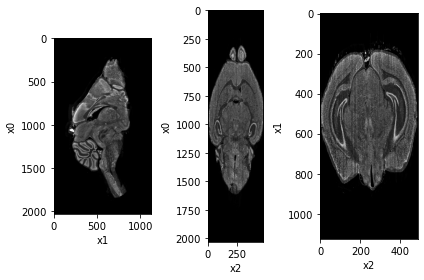

Loading fixed image stack
Finished loading 392 images


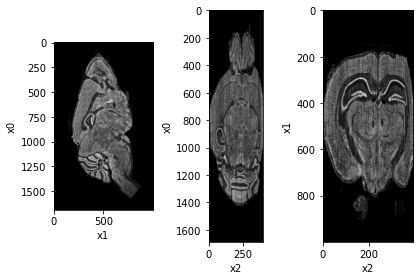

Normalizing image intensity
Padding image
Downsampling image


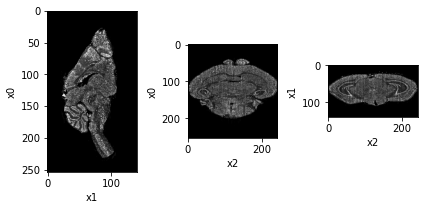

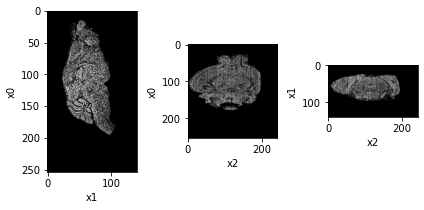

Converting to airlab image


In [7]:
mov_img, fix_img = load_and_prep_images(
    mov_img_dir, mov_img_thumb_dir,
    fix_img_dir, fix_img_thumb_dir,
    downsample_factor=(8, 8, 2)
)

In [8]:
transformation = affine_registrate(
    mov_img, fix_img,
    lr=1e-2, niter=64
)

0 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


mse: 0.015228313393890858 
1 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


mse: 0.014570772647857666 
2 mse: 0.014218807220458984 
3 mse: 0.013783772476017475 
4 mse: 0.013281818479299545 
5 mse: 0.012918522581458092 
6 mse: 0.012719381600618362 
7 mse: 0.012556507252156734 
8 mse: 0.012402207590639591 
9 mse: 0.012247804552316666 
10 mse: 0.012108957394957542 
11 mse: 0.011954414658248425 
12 mse: 0.011820407584309578 
13 mse: 0.011693546548485756 
14 mse: 0.01157184038311243 
15 mse: 0.011528227478265762 
16 mse: 0.01153792068362236 
17 mse: 0.011594164185225964 
18 mse: 0.011662974953651428 
19 mse: 0.0117166917771101 
20 mse: 0.011723426170647144 
21 mse: 0.011688741855323315 
22 mse: 0.011617553420364857 
23 mse: 0.011504133231937885 
24 mse: 0.011389708146452904 
25 mse: 0.01126659382134676 
26 mse: 0.011151328682899475 
27 mse: 0.011112626641988754 
28 mse: 0.011092737317085266 
29 mse: 0.011076708324253559 
30 mse: 0.011072216555476189 
31 mse: 0.011050804518163204 
32 mse: 0.011042594909667969 
33 mse: 0.011035636067390442 
34 mse: 0.0110218077898025

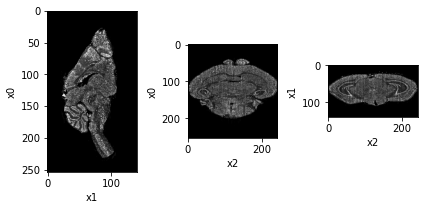

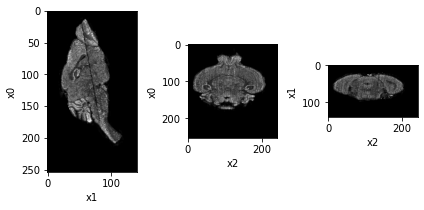

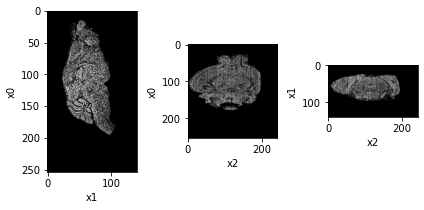

In [9]:
displacement = transformation.get_displacement()
wrp_img = al.transformation.utils.warp_image(mov_img, displacement)
imshow_midslice(mov_img.image[0,0].numpy())
imshow_midslice(wrp_img.image[0,0].numpy())
imshow_midslice(fix_img.image[0,0].numpy())

## Record the Transformation

In [10]:
affine_matrix = transformation.transformation_matrix.t().detach().numpy()
affine_matrix

array([[ 1.1612567 , -0.08495632, -0.01412426],
       [ 0.11392596,  1.0512772 ,  0.13211441],
       [-0.04379959, -0.45458832,  0.99004716],
       [ 0.13287124,  0.02968105,  0.12165445]], dtype=float32)

In [11]:
a = affine_matrix[:3,:]
t = affine_matrix[3,:]
a_inv = np.linalg.inv(a)
t_inv = - t @ a_inv
affine_matrix_inv = np.vstack((a_inv, t_inv))
affine_matrix_inv

array([[ 0.8543494 ,  0.07025844,  0.0028129 ],
       [-0.09202488,  0.8917625 , -0.1203119 ],
       [-0.00445764,  0.41256833,  0.95493513],
       [-0.11024477, -0.08599454, -0.11297488]], dtype=float32)

In [12]:
affine_transformation = {}
affine_transformation['mov_spacing'] = mov_img.spacing.tolist()
affine_transformation['fix_spacing'] = fix_img.spacing.tolist()
affine_transformation['box_size'] = list(fix_img.size)
affine_transformation['affine_matrix'] = affine_matrix_inv.tolist()
affine_transformation['affine_matrix_inv'] = affine_matrix.tolist()
with transformation_file.open('w') as f:
    json.dump(affine_transformation, f, indent=4)
affine_transformation

{'mov_spacing': [256.03151157065486, 256.0, 2.0],
 'fix_spacing': [256.07587433313574, 256.0, 2.0],
 'box_size': [254, 141, 243],
 'affine_matrix': [[0.8543493747711182,
   0.07025843858718872,
   0.0028128998819738626],
  [-0.09202487766742706, 0.8917624950408936, -0.12031190097332001],
  [-0.0044576446525752544, 0.4125683307647705, 0.9549351334571838],
  [-0.11024477332830429, -0.08599454164505005, -0.11297488212585449]],
 'affine_matrix_inv': [[1.1612566709518433,
   -0.08495631814002991,
   -0.01412426307797432],
  [0.11392595618963242, 1.0512771606445312, 0.13211441040039062],
  [-0.043799594044685364, -0.4545883238315582, 0.9900471568107605],
  [0.13287124037742615, 0.029681049287319183, 0.1216544508934021]]}